# Redes Convolucionales - LeNet

En este cuaderno, implementaremos una versión modificada de [LeNet-5](http://yann.lecun.com/exdb/lenet/), un modelo de red neuronal que utiliza capas de redes neuronales convolucionales (CNN) y que fue diseñado para [clasificar caracteres escritos a mano](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). Las CNN son ubicuas en la visión por computadora moderna. Casi todos los modelos de redes neuronales para visión por computadora contienen muchas capas CNN, también conocidas como capas convolucionales, por lo que son un concepto importante para comprender. Explicaremos cómo funcionan cuando implementemos el modelo.

La imagen a continuación muestra la arquitectura de LeNet-5. Consta de dos capas convolucionales, cada una seguida por una capa de submuestreo, y luego tres capas lineales totalmente conectadas.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)

Implementaremos LeNet, mediremos su rendimiento en el conjunto de datos MNIST y luego echaremos un breve vistazo para ver qué ha aprendido el modelo.

### Procesamiento de Datos

Como siempre, importaremos los módulos que necesitamos...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

...establecer la semilla aleatoria para reproducibilidad...

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

...y calcular la media y la desviación estándar en nuestro conjunto de entrenamiento para poder normalizar nuestros datos.

In [3]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Media Calculada: {mean}')
print(f'STD Calculada: {std}')

100%|██████████| 9912422/9912422 [00:00<00:00, 91454383.01it/s]


Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 47355626.98it/s]


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22750241.44it/s]


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7029715.41it/s]


Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw

Media Calculada: 0.13066047430038452
STD Calculada: 0.30810779333114624


Luego, definiremos nuestras transformaciones de entrenamiento y prueba...

In [4]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

...cargar nuestros datos de entrenamiento y prueba...

In [5]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

...y crear un conjunto de validación a partir del 10% de nuestros datos de entrenamiento.

Recuerda que el conjunto de validación siempre debe tomarse de los datos de entrenamiento y nunca de los datos de prueba.

In [6]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

El conjunto de validación utiliza las mismas transformaciones que el conjunto de entrenamiento, ya que se creó a partir de este último. Dado que queremos que nuestro conjunto de validación permanezca estático para que se parezca más a nuestro conjunto de prueba, las reemplazamos con las transformaciones de prueba, recordando hacer una "copia profunda" (deepcopy) del conjunto de validación.

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Imprimiremos el número de ejemplos en los conjuntos de entrenamiento, validación y prueba para asegurarnos de que todo se haya cargado correctamente.

In [8]:
print(f'Número de ejemplos de entrenamiento: {len(train_data)}')
print(f'Número de ejemplos de validación: {len(valid_data)}')
print(f'Número de ejemplos de prueba: {len(test_data)}')

Número de ejemplos de entrenamiento: 54000
Número de ejemplos de validación: 6000
Número de ejemplos de prueba: 10000


La última parte de la etapa de procesamiento de datos es crear nuestros dataloaders/iteradores.

Utilizamos un tamaño de lote de 64 y solo mezclamos los datos de entrenamiento en cada época.

In [9]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Definiendo el Modelo

Las arquitecturas LeNet, y casi todas las arquitecturas modernas de redes neuronales para visión por computadora, utilizan capas de redes neuronales convolucionales (CNN).

Entonces, ¿qué es una capa CNN? Cada capa convolucional tiene una serie de *filtros*, comúnmente referidos como *kernels*. Un filtro es una matriz (generalmente) cuadrada que se desliza sobre los píxeles de una imagen de izquierda a derecha y de arriba a abajo. En cada "paso", el filtro realiza una operación de [convolución](https://es.wikipedia.org/wiki/Convoluci%C3%B3n) en la imagen. La salida de la capa convolucional es el resultado de estas convoluciones después del último "paso" del filtro.

**Nota:** En los frameworks de machine learning, no hay realmente "pasos", el resultado para cada ubicación del filtro se calcula al mismo tiempo, en paralelo. Esto es mucho más rápido que avanzar realmente a través de la imagen, pero pensar en términos de pasos facilita la visualización.

Echemos un vistazo a un solo filtro de 2x2 que pasa sobre una imagen. Pretenderemos que la imagen es de 10x10 píxeles en este ejemplo.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/filter-mnist.png?raw=1)

El filtro (en rojo) se desliza sobre los píxeles de la imagen, avanzando un píxel a la vez. El tamaño de los pasos se llama *stride*, y en esta implementación usamos un stride de uno, lo que significa que el filtro se mueve un píxel a la vez horizontalmente y se mueve un píxel hacia abajo una vez que llega al final de una fila. El resultado de la operación de convolución (en verde) es un píxel en la imagen filtrada. Todas estas convoluciones producen una nueva imagen filtrada.

Observa cómo la imagen que sale de la capa CNN es más pequeña que la imagen que entra en la CNN. Esto se debe a que el filtro de 2x2 tiene solo nueve pasos en horizontal y vertical. Si quisiéramos mantener el tamaño de la imagen de salida igual que el de la imagen de entrada, podríamos agregar relleno o padding (generalmente píxeles negros) alrededor de nuestra imagen.

Cuando no tenemos relleno y un paso de uno, el tamaño de la imagen de salida se calcula de la siguiente manera:

$$\text{alto}_{\text{salida}} = \text{alto}_{\text{entrada}} - \text{alto}_{\text{filtro}} + 1$$

$$\text{ancho}_{\text{salida}} = \text{ancho}_{\text{entrada}} - \text{ancho}_{\text{filtro}} + 1$$

¿Cómo calculamos los valores de los píxeles de salida utilizando el filtro? ¡Es simplemente multiplicar y sumar! Cada uno de los píxeles de la imagen de entrada cubiertos por un filtro se multiplica por el peso del filtro sobre ese píxel. Todos estos productos se suman para obtener el valor del píxel en la imagen de salida.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-filter.png?raw=1)

Los mismos pesos se utilizan para el filtro en toda la imagen. Los pesos no cambian según la ubicación del filtro dentro de la imagen. Una ventaja de esto es que los filtros (y las propias capas convolucionales) son *invariantes a la traslación*, lo que significa que no importa dónde aparezca una característica (curva, borde, línea) en una imagen, la capa convolucional encontrará todas las ocurrencias de ella.

Los pesos de los filtros, al igual que los pesos de las capas lineales en perceptrones multicapa, se aprenden mediante el descenso de gradientes y la retropropagación.

¿Por qué las redes neuronales convolucionales están estructuradas de esta manera? Los filtros aplicados de esta manera en una imagen se pueden usar para detectar patrones como líneas horizontales y verticales dentro de una imagen. Estos patrones se pueden considerar como características de la imagen, que nuestra CNN extrae. Estas características extraídas luego se pueden combinar en capas posteriores de la red neuronal con otras características extraídas y juntas crear características de nivel superior, por ejemplo, una cierta posición y orientación de dos líneas para hacer una cruz, que puede indicar el centro de un número manuscrito.

Las CNN también se inspiran en técnicas clásicas de visión por computadora, como los [filtros Sobel](https://es.wikipedia.org/wiki/Operador_Sobel). Intentemos elegir manualmente los pesos de un filtro de 3x3 para crear filtros Sobel y apliquémoslos a algunos dígitos MNIST para ver qué tipo de cosas pueden aprender nuestras capas CNN.

La función `plot_filter` toma un lote de imágenes y un filtro bidimensional y muestra la salida de ese filtro aplicado a todas las imágenes.

In [10]:
def plot_filter(images, filter):

    images = images = torch.cat([i.unsqueeze(0) for i in images],
                                dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Filtrada')
        ax.axis('off')

Luego obtendremos un lote de imágenes para probar nuestros filtros Sobel escritos a mano. Obtenemos las imágenes del conjunto de prueba, ya que es más fácil examinarlas sin las transformaciones aplicadas a ellas.

In [11]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

El primer filtro es para detectar líneas horizontales.

Podemos observar en las imágenes filtradas que los valores más altos (los píxeles más blancos) de la imagen filtrada se encuentran donde hay una línea horizontal que es negra en la parte superior y blanca debajo, por ejemplo, en la parte superior del dígito 7. Los valores más bajos (los píxeles más negros) de la imagen filtrada se encuentran donde hay una línea horizontal que va de blanco a negro, por ejemplo, en la parte inferior de todos los dígitos.

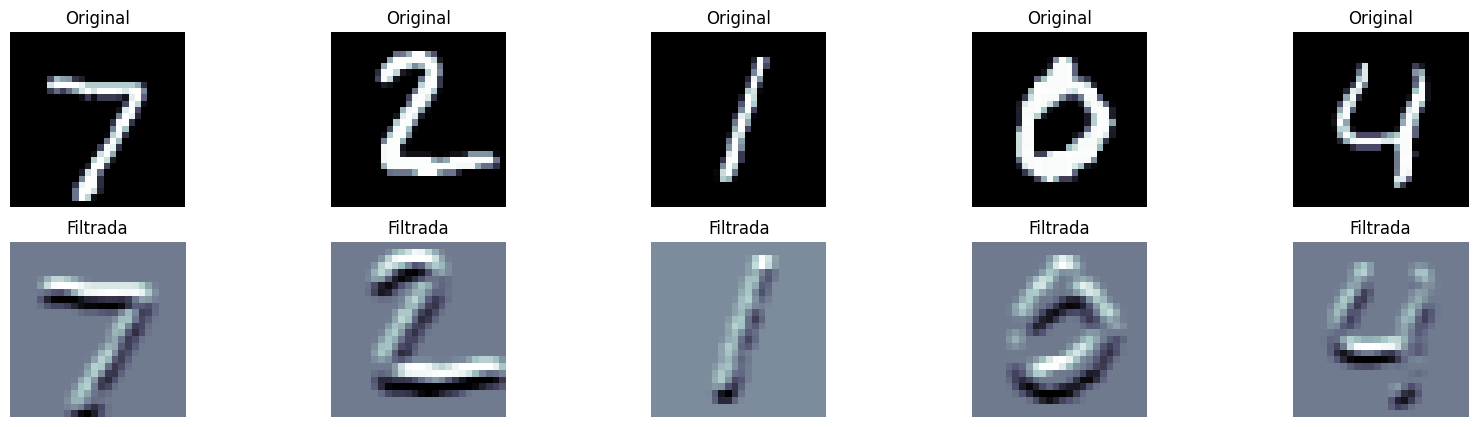

In [12]:
horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

Al intercambiar la primera y última fila del filtro anterior, obtenemos un filtro que detecta líneas horizontales desde el blanco en la parte superior hasta el negro debajo.

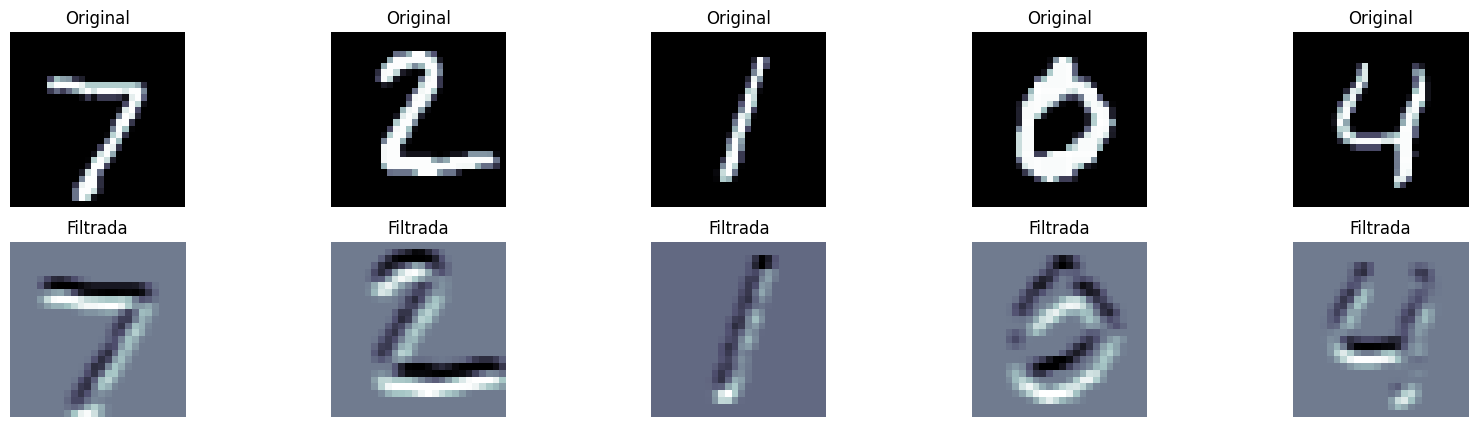

In [13]:
horizontal_filter = [[ 1,  2,  1],
                     [ 0,  0,  0],
                     [-1, -2, -1]]

plot_filter(images, horizontal_filter)

También podemos diseñar filtros que detecten líneas verticales.

Aquí tienes uno que detecta líneas verticales que son negras a la izquierda y blancas a la derecha.

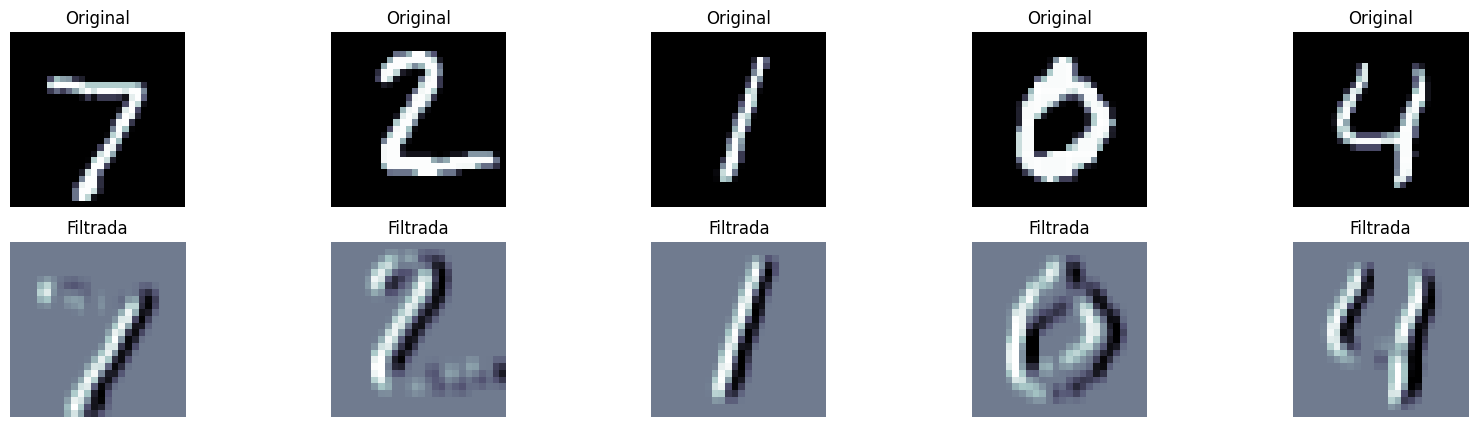

In [14]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

Para obtener el filtro opuesto, uno que detecta líneas verticales que son blancas a la izquierda y negras a la derecha, intercambiamos las columnas izquierda y derecha.

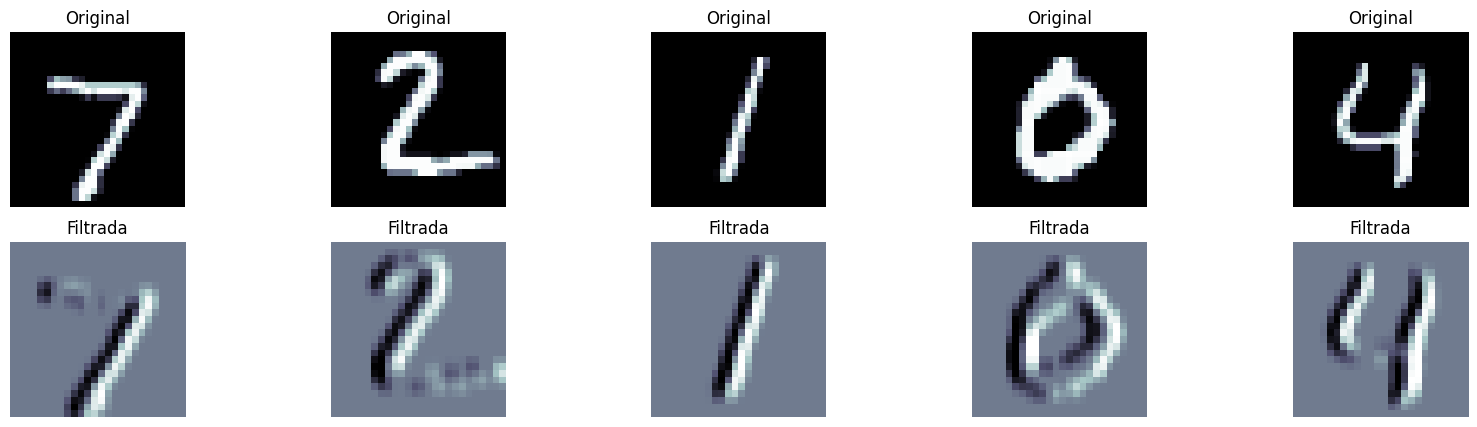

In [15]:
vertical_filter = [[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]]

plot_filter(images, vertical_filter)

Finalmente, diseñaremos un filtro que detecte diagonales. Este detecta líneas que apuntan hacia la parte superior derecha de la imagen.

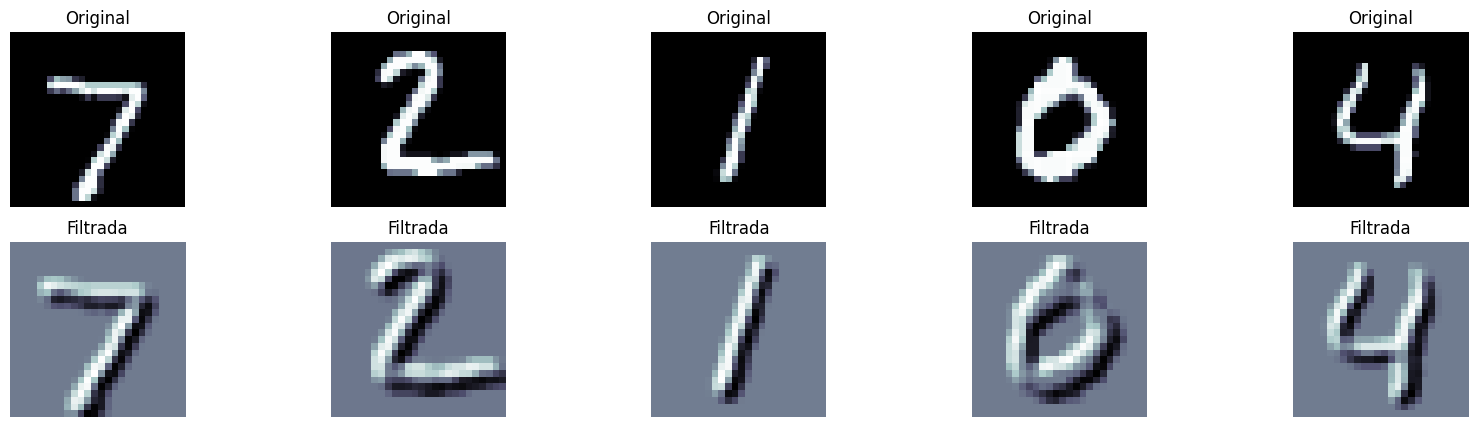

In [16]:
diagonal_filter = [[-2, -1, 0],
                   [-1,  0, 1],
                   [ 0,  1, 2]]

plot_filter(images, diagonal_filter)

Lo genial de las capas convolucionales es que cada capa no tiene solo un solo filtro. Puede tener tantos filtros como desees. Cada filtro tiene su propio conjunto de pesos, por lo que (en teoría) aprende a extraer características diferentes.

La imagen a continuación muestra lo que sucede cuando usamos una capa convolucional con cinco filtros. La imagen original con un solo canal de color (ya que es en blanco y negro) tiene cinco filtros aplicados para obtener cinco imágenes filtradas. Estas imágenes se apilan juntas para obtener lo que podemos pensar como una sola imagen con cinco canales.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-filter-mnist.png?raw=1)

¿Y qué sucede cuando deseas pasar esta imagen filtrada de cinco canales a otra capa convolucional? Ahora, esa capa convolucional no solo tendrá altura y ancho, sino que también tendrá una profundidad igual al número de canales en la imagen de entrada.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-channel-mnist.png?raw=1)

Como puedes ver, el filtro tiene una altura, ancho y profundidad de 2x2x5. Todos los 20 valores de píxeles cubiertos por este filtro se multiplican por el peso del filtro y luego se suman. El resultado de esto tendrá tantos canales como filtros haya, y una capa convolucional subsiguiente deberá tener filtros con una profundidad igual a ese número de canales.

Con suerte, esto es suficiente sobre las capas convolucionales, pero si no, hay [muchos](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) [otros](https://cs231n.github.io/convolutional-networks/) [recursos](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) [en línea](https://www.coursera.org/learn/convolutional-neural-networks) sobre ellas.

A continuación, hablaremos sobre las capas de submuestreo. Estas son capas utilizadas para reducir el tamaño/resolución de su entrada y se aplican comúnmente a la salida de las capas convolucionales. Los dos métodos más comunes de submuestreo son *max pooling* y *mean pooling* (también conocido como *average pooling*), y por lo tanto, el submuestreo a menudo se conoce como *pooling*.

¿Por qué queremos reducir la resolución de la imagen? Esto acelera nuestro modelo, ya que las operaciones de convolución son costosas. Si reducimos la resolución a la mitad de nuestra imagen antes de pasarla a la siguiente capa convolucional, eso representa una aceleración significativa.

Las capas de submuestreo no son muy diferentes de las capas convolucionales. Tienen un filtro con un tamaño y un paso. Sin embargo, las capas de submuestreo no tienen parámetros, como pesos y sesgos. Simplemente realizan una operación en la imagen. Max pooling devuelve el valor máximo de los valores cubiertos por el filtro, y podemos pensar en ello como la extracción de la característica más importante bajo el filtro. El pooling de media/deviación estándar devuelve la media/deviación estándar de los valores cubiertos por el filtro, y podemos pensar en ello como la ponderación equitativa de todas las características bajo el filtro.

Echemos un vistazo a una operación de submuestreo de 2x2, con un paso de 2, en una imagen:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/subsample-mnist.png?raw=1)

Comúnmente, y de forma predeterminada en PyTorch, el paso para la altura y el ancho es igual a la altura y el ancho del filtro, y cada píxel solo es visto una vez por la capa de submuestreo, por lo tanto:

$$\text{alto}_{\text{salida}} = \frac{\text{alto}_\text{entrada}}{\text{alto}_{\text{filtro}}}$$

$$\text{ancho}_{\text{salida}} = \frac{\text{ancho}_\text{entrada}}{\text{ancho}_{\text{filtro}}}$$

Para max pooling, el valor de salida para cada ubicación del filtro es:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-pool.png?raw=1)

Creemos una función que nos permita ver las salidas de una capa de submuestreo en un lote de imágenes.

In [17]:
def plot_subsample(images, pool_type, pool_size):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type debe ser bien max o mean, ingresó: {pool_type}')

    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size=pool_size)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Submuestreo')
        ax.axis('off')

Primero, veamos el submuestreo máximo (max pooling) con un tamaño de filtro de 2.

Podemos ver que la imagen se reduce significativamente en tamaño/resolución y en calidad.

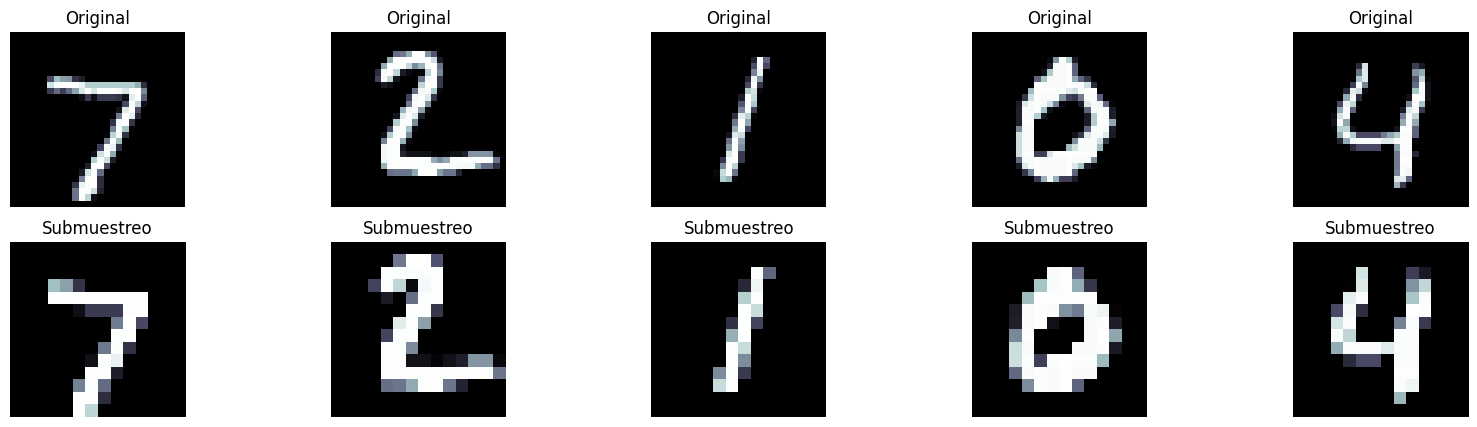

In [18]:
plot_subsample(images, 'max', 2)

Si aumentamos el tamaño del filtro de submuestreo máximo (max pooling), las imágenes se vuelven más pequeñas y la calidad empeora.

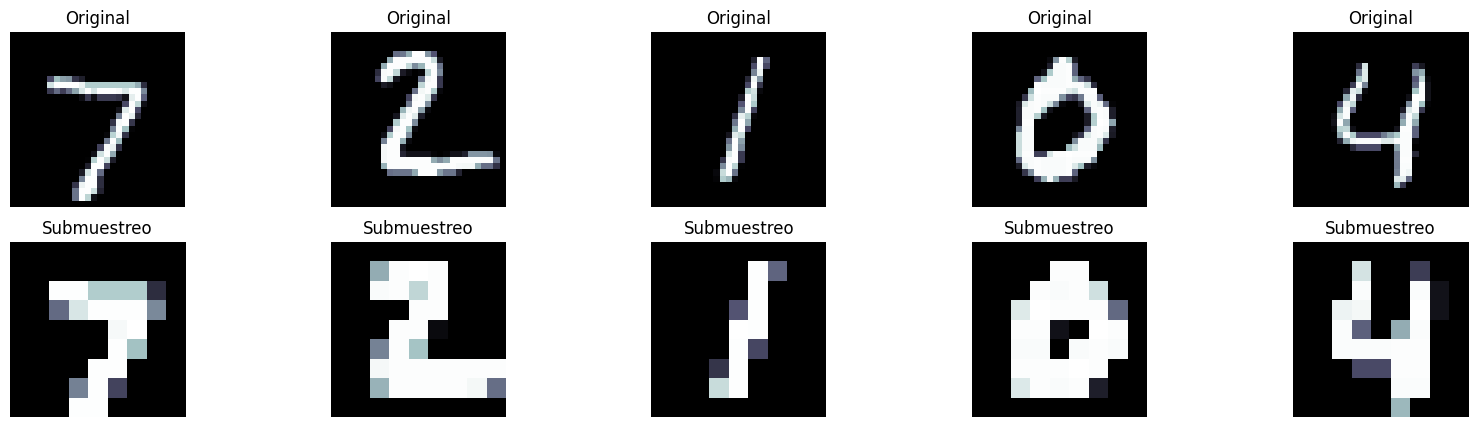

In [19]:
plot_subsample(images, 'max', 3)

Para el submuestreo promedio (average pooling), ocurre el mismo efecto, aunque la pérdida de calidad no es tan drástica.

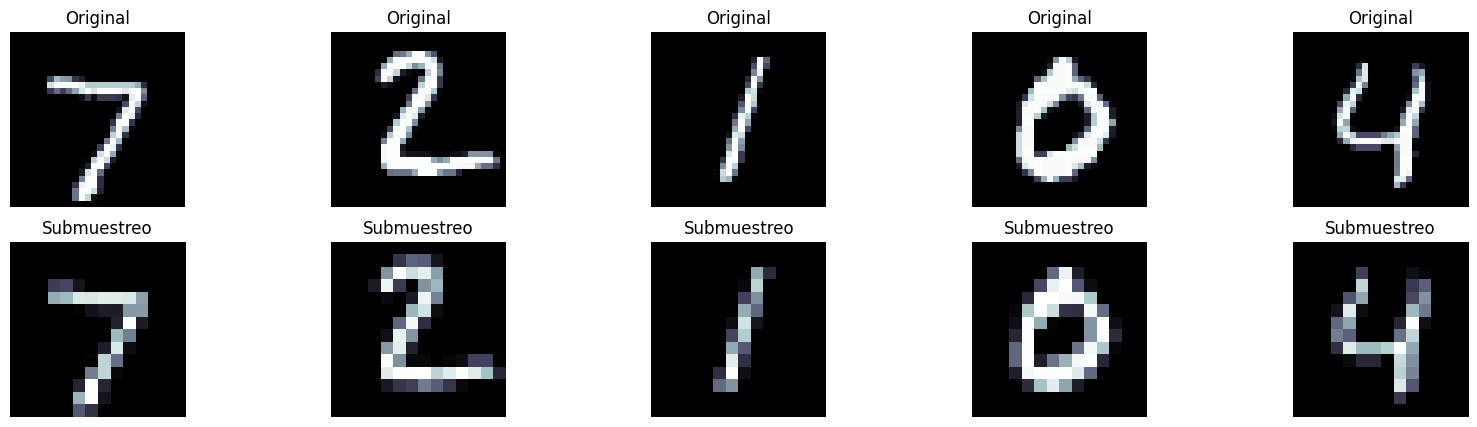

In [20]:
plot_subsample(images, 'avg', 2)

Nuevamente, podemos aumentar el tamaño del filtro, lo que reduce la resolución de la imagen de salida a costa de la calidad de la imagen. Sin embargo, la disminución de calidad no es tan severa como en el caso del submuestreo máximo (max pooling).

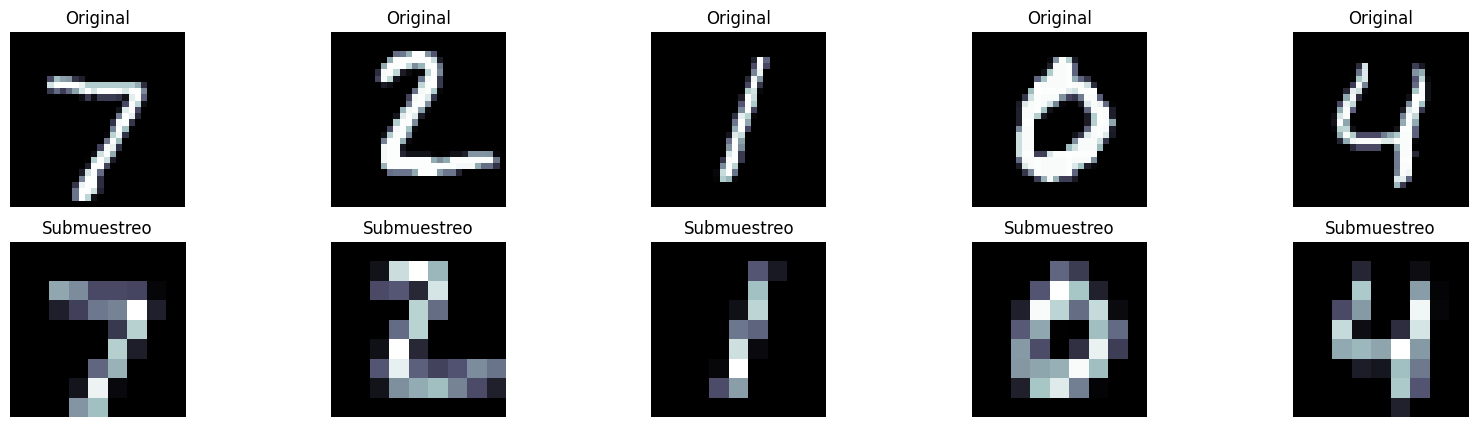

In [21]:
plot_subsample(images, 'avg', 3)

De manera similar a las capas convolucionales, si la imagen de entrada tiene más de un canal, el filtro tiene una profundidad igual al número de canales. Por lo tanto, si hiciéramos un grupo máximo con un filtro de 5x5x6 (alto y ancho de 5 y profundidad de 6), la salida en cada píxel sería el valor máximo de los 150 píxeles cubiertos por el filtro.




### Definiendo el Modelo

Ahora que hemos repasado todos los conceptos, podemos implementar nuestro modelo.

![Imagen de LeNet-5](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)

Nuestra implementación real va a diferir ligeramente de la arquitectura real de LeNet, ya que esta fue diseñada para manejar imágenes de 32x32, mientras que el conjunto de datos MNIST consiste en imágenes de 28x28. Tampoco vamos a usar las conexiones gaussianas al final, en su lugar, utilizaremos una capa lineal estándar.

La primera capa en nuestro modelo es una capa convolucional con 6 filtros (PyTorch los llama `out_channels`) y un tamaño de kernel de 5. Esto convierte nuestra imagen `[1, 28, 28]` en `[6, 24, 24]`. Luego reducimos el tamaño de nuestra imagen con una capa de submuestreo máximo (max pooling) que tiene un tamaño de filtro de 2 para obtener una imagen `[6, 12, 12]`. Luego se pasa por una función de activación, en este caso ReLU, que se aplica elemento a elemento y no cambia el tamaño de la imagen.

Después, pasamos la imagen a la segunda capa convolucional con 16 filtros que son 5x5x6, una altura y ancho de 5 y una profundidad de 6, ya que nuestra capa convolucional anterior tenía 6 filtros. Esto nos da una imagen de tamaño `[16, 8, 8]`, que luego reducimos a la mitad en altura y ancho a `[16, 4, 4]` y luego pasamos por otra función ReLU.

Luego aplanamos nuestra imagen `[16, 4, 4]` a `[256]` y la pasamos por tres capas lineales. Cada una de las capas lineales está seguida por otra ReLU, excepto la última.

Devolvemos los resultados de la última capa lineal, así como el resultado aplanado de la segunda capa convolucional, que podemos representar en dimensiones más bajas más tarde.

Ten en cuenta que siempre debes aplicar tu función de activación **después** de la capa de submuestreo (pooling). Obtendrás los mismos resultados si aplicas la función de activación antes, sin embargo, esto significa que aplicarás la función de activación a un mayor número de entradas, lo que aumenta el cálculo requerido. Usar la función de activación después de que la imagen se haya reducido en tamaño significa que se aplicará a menos entradas y, por lo tanto, utilizará menos cálculos.

In [22]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 4 * 4, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):

        # x = [batch size, 1, 28, 28]

        x = self.conv1(x)

        # x = [batch size, 6, 24, 24]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 6, 12, 12]

        x = F.relu(x)

        x = self.conv2(x)

        # x = [batch size, 16, 8, 8]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 16, 4, 4]

        x = F.relu(x)

        x = x.view(x.shape[0], -1)

        # x = [batch size, 16*4*4 = 256]

        h = x

        x = self.fc_1(x)

        # x = [batch size, 120]

        x = F.relu(x)

        x = self.fc_2(x)

        # x = batch size, 84]

        x = F.relu(x)

        x = self.fc_3(x)

        # x = [batch size, output dim]

        return x, h

Crearemos una instancia del modelo...

In [23]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

...y calcularemos el número de parámetros.

Observa que este modelo tiene alrededor de 44,000 parámetros

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'El modelo tiene {count_parameters(model):,} parametros entrenables')

El modelo tiene 44,426 parametros entrenables


### Entrenando el Modelo

Definimos nuestro optimizador...

In [25]:
optimizer = optim.Adam(model.parameters())

...nuestra función de pérdida (que también aplicará la función de activación softmax)...

In [26]:
criterion = nn.CrossEntropyLoss()

...definimos el dispositivo (para colocar nuestro modelo y datos en la GPU, si la tenemos)...

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

...colocamos el modelo y el criterio en el dispositivo...

In [28]:
model = model.to(device)
criterion = criterion.to(device)

...definimos una función para calcular la precisión (accuracy)...

In [29]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...definimos una función que realiza una época de entrenamiento (epoch)...

In [31]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Entrenando", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...definimos una función que realiza una época de evaluación...

In [32]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluando", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...definimos una función que nos dice cuánto tiempo dura una época...

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

¡Y finalmente podemos comenzar el entrenamiento!

A pesar de tener significativamente menos parámetros que un modelo FNN, el modelo todavía lleva aproximadamente la misma cantidad de tiempo por época (las capas convolucionales son computacionalmente costosas) y lo entrenamos un poco más.

Sin embargo, podemos superar la precisión de validación que en el caso del modelo FNN.

In [34]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    #definimos el uso de donde guuardar las metricas
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    #si la validacion de la epoca supera a la guardada
    #salvamos estos nuevos pesos en el archivo
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 39s
	Train Loss: 0.418 | Train Acc: 86.56%
	 Val. Loss: 0.118 |  Val. Acc: 96.45%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 29s
	Train Loss: 0.138 | Train Acc: 95.60%
	 Val. Loss: 0.081 |  Val. Acc: 97.73%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 30s
	Train Loss: 0.101 | Train Acc: 96.74%
	 Val. Loss: 0.076 |  Val. Acc: 97.85%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 30s
	Train Loss: 0.085 | Train Acc: 97.37%
	 Val. Loss: 0.058 |  Val. Acc: 98.29%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 29s
	Train Loss: 0.070 | Train Acc: 97.80%
	 Val. Loss: 0.055 |  Val. Acc: 98.40%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 30s
	Train Loss: 0.066 | Train Acc: 97.96%
	 Val. Loss: 0.056 |  Val. Acc: 98.45%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 29s
	Train Loss: 0.060 | Train Acc: 98.16%
	 Val. Loss: 0.047 |  Val. Acc: 98.68%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 30s
	Train Loss: 0.053 | Train Acc: 98.33%
	 Val. Loss: 0.042 |  Val. Acc: 98.72%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 30s
	Train Loss: 0.052 | Train Acc: 98.32%
	 Val. Loss: 0.040 |  Val. Acc: 98.77%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 30s
	Train Loss: 0.047 | Train Acc: 98.52%
	 Val. Loss: 0.045 |  Val. Acc: 98.71%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 30s
	Train Loss: 0.047 | Train Acc: 98.56%
	 Val. Loss: 0.047 |  Val. Acc: 98.72%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 30s
	Train Loss: 0.046 | Train Acc: 98.56%
	 Val. Loss: 0.044 |  Val. Acc: 98.84%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 30s
	Train Loss: 0.042 | Train Acc: 98.67%
	 Val. Loss: 0.040 |  Val. Acc: 98.85%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 30s
	Train Loss: 0.040 | Train Acc: 98.73%
	 Val. Loss: 0.041 |  Val. Acc: 99.00%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 30s
	Train Loss: 0.040 | Train Acc: 98.73%
	 Val. Loss: 0.038 |  Val. Acc: 98.94%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 30s
	Train Loss: 0.037 | Train Acc: 98.82%
	 Val. Loss: 0.047 |  Val. Acc: 98.60%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 30s
	Train Loss: 0.035 | Train Acc: 98.88%
	 Val. Loss: 0.042 |  Val. Acc: 98.76%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 30s
	Train Loss: 0.033 | Train Acc: 98.94%
	 Val. Loss: 0.037 |  Val. Acc: 98.96%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 30s
	Train Loss: 0.033 | Train Acc: 98.97%
	 Val. Loss: 0.039 |  Val. Acc: 98.95%


Entrenando:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 30s
	Train Loss: 0.034 | Train Acc: 98.94%
	 Val. Loss: 0.040 |  Val. Acc: 98.85%


Cargamos los parámetros que funcionaron mejor en el conjunto de validación y luego evaluamos nuestro rendimiento en el conjunto de prueba.



In [35]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluando:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.025 | Test Acc: 99.21%


¡Al igual que con la precisión de validación, obtenemos una precisión de prueba del 99%!

### Examinando el Modelo

Examinaremos nuestro modelo trazando una matriz de confusión, viendo cuáles son los ejemplos incorrectos en los que nuestro modelo tenía más confianza, visualizando las representaciones aprendidas por nuestro modelo en dos dimensiones con PCA y t-SNE, y viendo los pesos de nuestro modelo.

Primero, obtendremos las predicciones del modelo en todo el conjunto de pruebas...

In [36]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [37]:
images, labels, probs = get_predictions(model, test_iterator, device)

...y luego obtenemos las etiquetas predichas a partir de las predicciones del modelo.

In [38]:
pred_labels = torch.argmax(probs, 1)

A continuación, trazaremos la matriz de confusión.

In [39]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

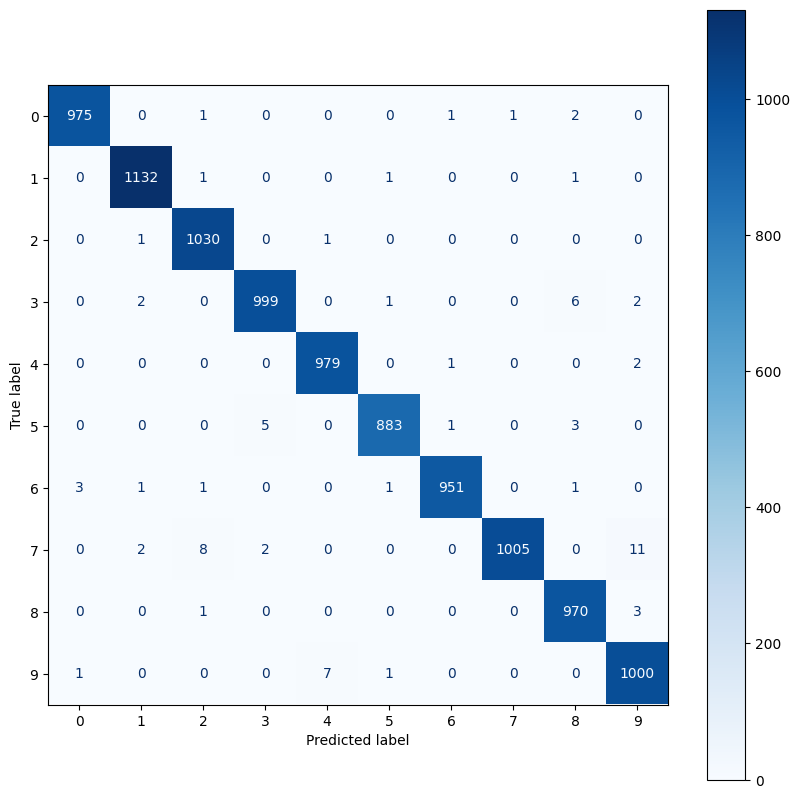

In [40]:
plot_confusion_matrix(labels, pred_labels)

El único problema real que parece tener el modelo es predecir 2s como 7s.

A continuación, averiguaremos cuáles de nuestros ejemplos son correctos...

In [41]:
corrects = torch.eq(labels, pred_labels)

...luego obtenemos todos los ejemplos incorrectos y los ordenamos por confianza descendente en su predicción.

In [42]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

Podemos usar esto para trazar los ejemplos que el modelo clasificó incorrectamente y en los que tenía más confianza.

In [43]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'Etiqueta real: {true_label} ({true_prob:.3f})\n'
                     f'Etiqueta predicha: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

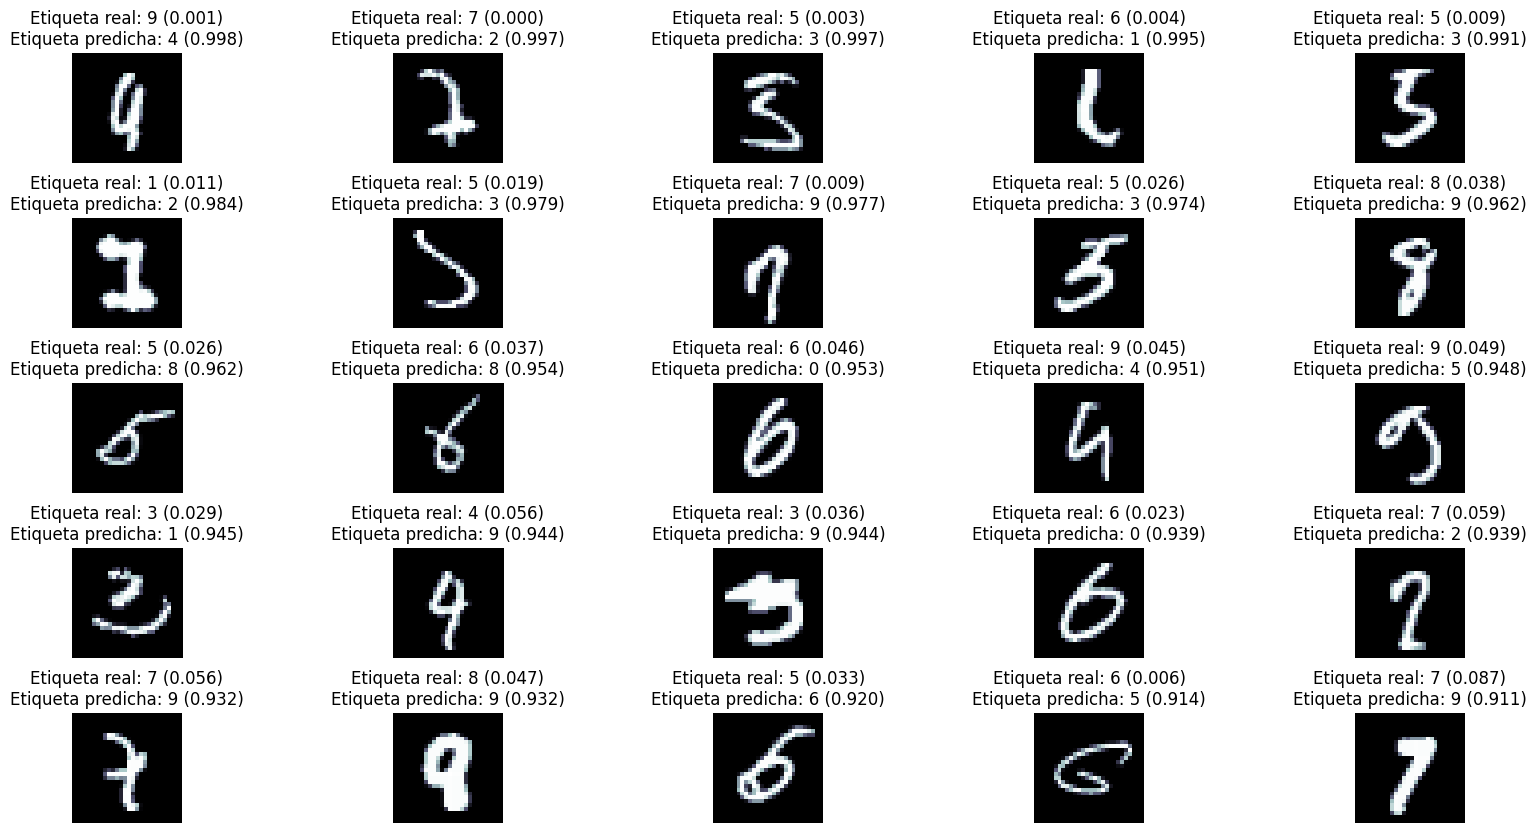

In [44]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

Los errores parecen bastante razonables. Todos los dígitos mostrados aquí están un poco fuera de lugar.

El modelo siempre se entrena para tener una confianza increíble en sus predicciones, por lo que no es inusual que sea extremadamente seguro cuando está equivocado.

Sigamos con la visualización de las representaciones del modelo en dimensiones más bajas para poder visualizarlas.

Primero, obtendremos las representaciones del modelo...

In [45]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [46]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/844 [00:00<?, ?it/s]

...y luego calcularemos el PCA (Principal Component Analysis) en las representaciones.

In [47]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [48]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

Luego, trazamos las representaciones PCA.

Incluso cuando las clases se superponían en las representaciones PCA, la matriz de confusión mostraba que no se mezclaban con frecuencia en absoluto.

In [49]:
output_pca_data = get_pca(outputs)

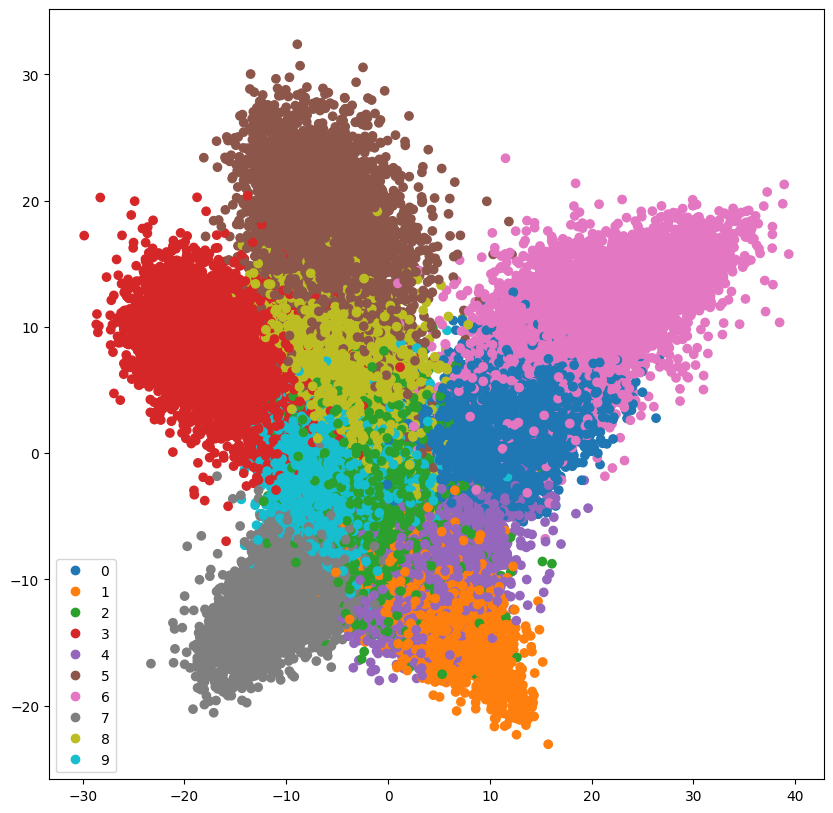

In [50]:
plot_representations(output_pca_data, labels)

Trazando las representaciones PCA de los valores intermedios, justo después del segundo conjunto de capas de convolución y submuestreo.

Podemos ver que muchas de las clases se superponen en un gran grupo. Intuitivamente, esto tiene sentido, ya que el modelo solo ha extraído las características de la imagen hasta ahora y aún no las ha pasado a las capas lineales que ponderarán estas características para hacer una predicción real.

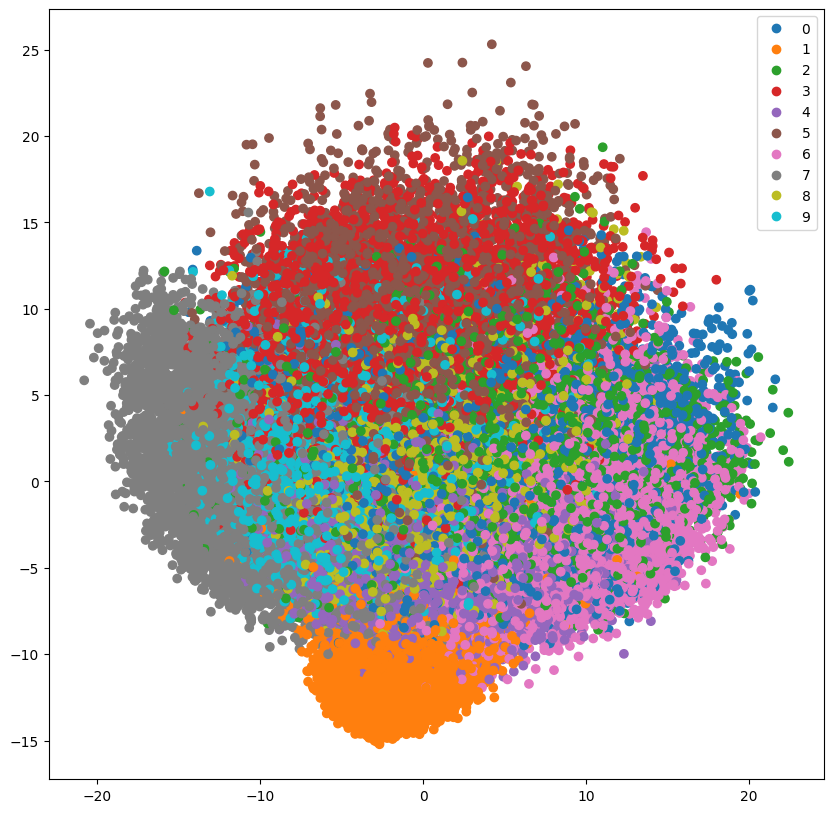

In [51]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

Repetimos el proceso para t-SNE. Solo usamos un subconjunto de los datos, ya que t-SNE lleva bastante tiempo.

In [52]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

Primero, las representaciones de salida. t-SNE hace un buen trabajo separando las clases.

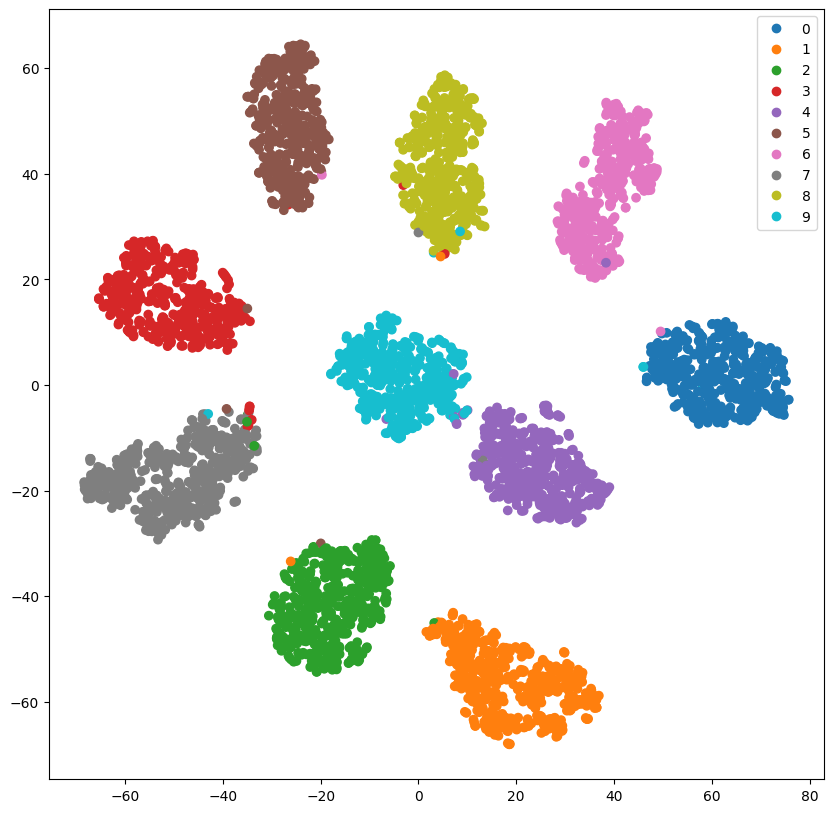

In [53]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

Nuevamente, las representaciones intermedias están más agrupadas, lo que añade más evidencia a la teoría de que esto es simplemente una representación de las características extraídas antes de que las capas lineales tengan la oportunidad de ponderar la presencia o ausencia de ciertas características extraídas.

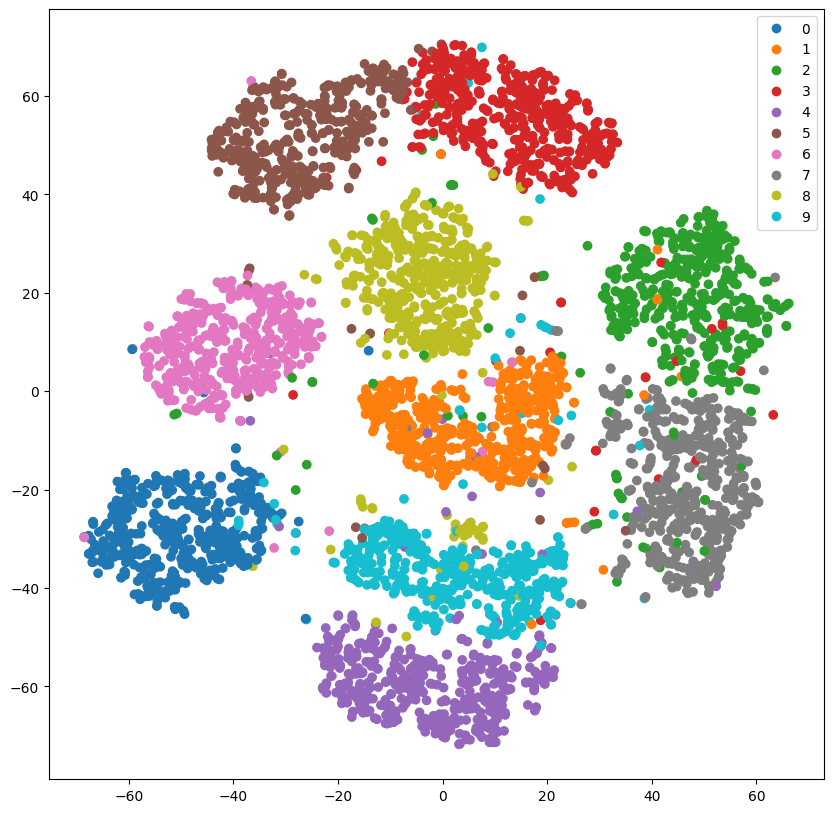

In [54]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

Podemos intentar generar un dígito escrito a mano perfecto generando repetidamente un lote de ruido y almacenando el ruido que nos dio la mayor probabilidad de ser el dígito que queremos.

¿Podremos lograrlo?..

In [55]:
def imagine_digit(model, digit, device, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 1, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

Como podemos ver a continuación, no. Obtenemos ruido aleatorio con una confianza superior al 99% de que es un tres.

Nuevamente, nuestro modelo ha sido entrenado para tener confianza en sus predicciones y, por lo tanto, lo será incluso para el ruido aleatorio. Esto es una limitación de las redes neuronales y es una de las razones por las que [los ejemplos de redes adversarias](https://openai.com/blog/adversarial-example-research/) funcionan tan bien.

In [56]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [57]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 98.29%


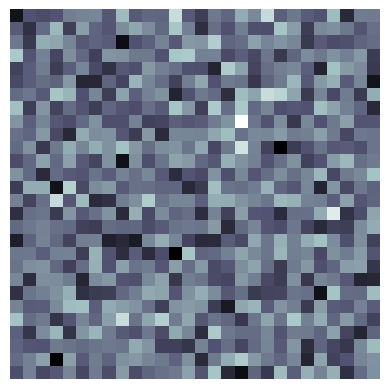

In [58]:
plt.imshow(best_image.squeeze(0).cpu().numpy(), cmap='bone')
plt.axis('off');

Recuerda cómo definimos los filtros Sobel al principio de este tutorial. Bueno, como las capas convolucionales aprenden sus propios valores para sus filtros, podemos hacer lo mismo y ver cómo nuestros filtros procesan imágenes.

Definamos una función que tome un lote de imágenes y múltiples filtros, y luego los aplique a las imágenes.

In [59]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filtro {j+1}')
            ax.axis('off')

Algunos de nuestros filtros buscan áreas de píxeles negros, lo que tiene el efecto de invertir nuestras imágenes. Algunos aplican un efecto de desenfoque, que es similar a los efectos de [desenfoque gaussiano](https://es.wikipedia.org/wiki/Desenfoque_gaussiano) utilizados en el procesamiento de imágenes para reducir el ruido en la imagen. Algunos detectan bordes, como nuestros filtros Sobel que creamos anteriormente.

No hay garantía de que cada filtro aprenda un efecto de filtrado único. Se inicializan de forma aleatoria, y algunos filtros pueden aprender pesos muy similares. Por lo tanto, no necesariamente significa que usar más filtros dará un mejor rendimiento.

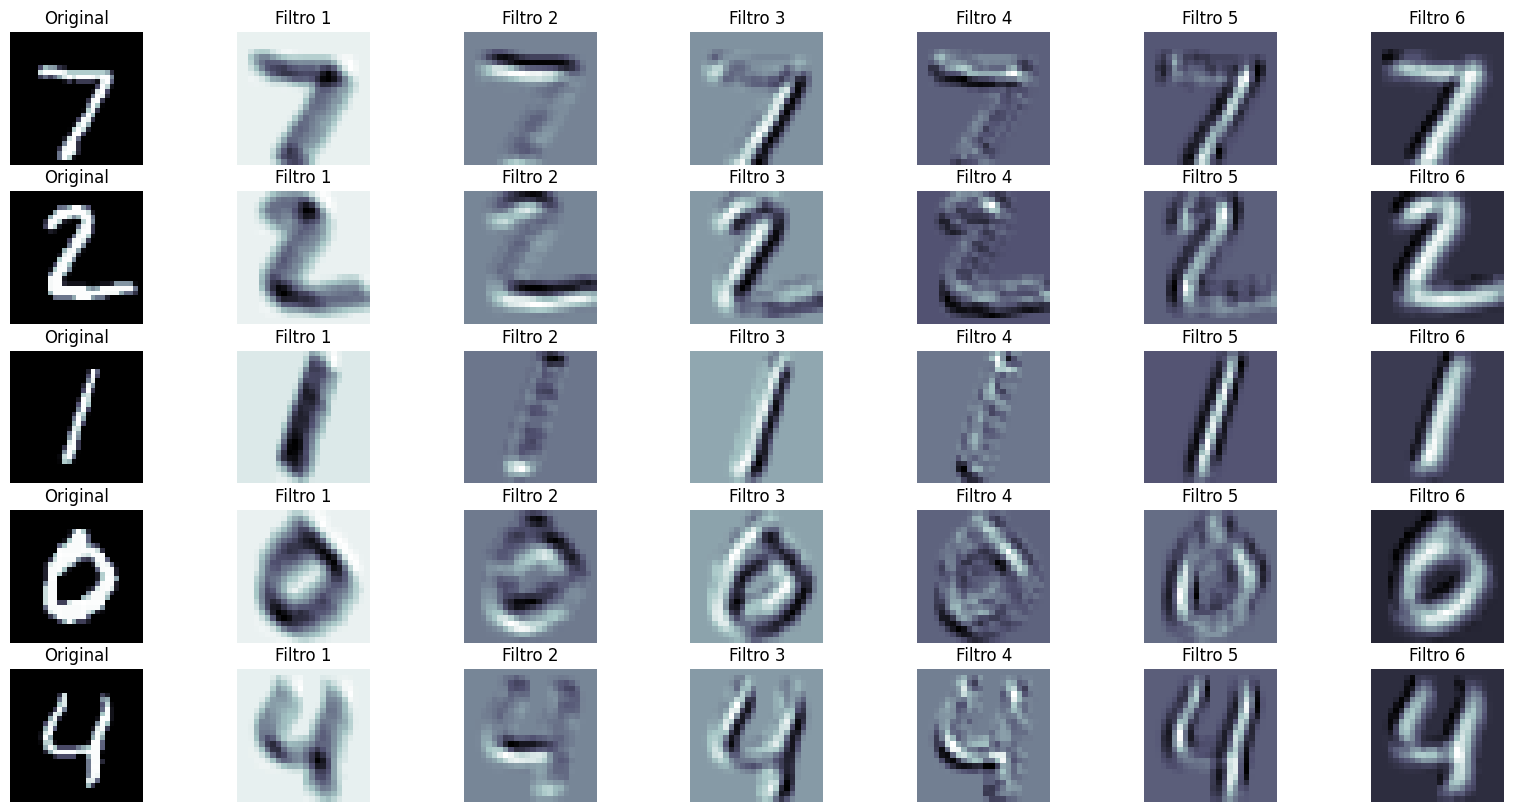

In [60]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters)

Veamos cómo se ve nuestro mejor dígito imaginado después de pasar por nuestros filtros.

Obtenemos algunos patrones agradables, pero eso es todo.

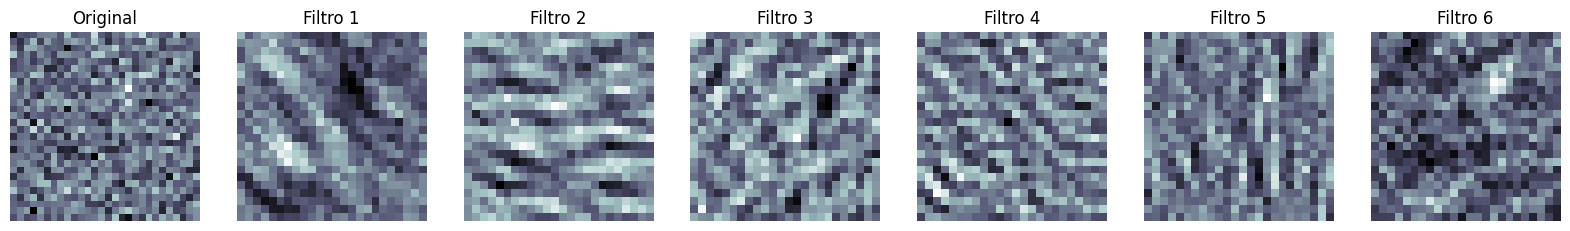

In [61]:
plot_filtered_images([best_image], filters)

Finalmente, trazaremos los propios filtros.

In [62]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_filters):

        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filters[i].squeeze(0), cmap='bone')
        ax.axis('off')

Se pueden ver algunos patrones, pero es difícil interpretar qué han aprendido realmente estos filtros.

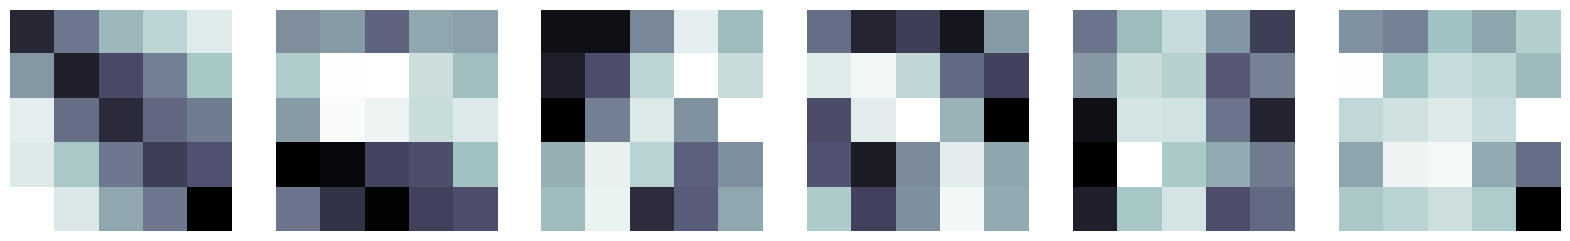

In [63]:
plot_filters(filters)

### Conclusiones

En este cuaderno, hemos mostrado:
- Cómo cargar conjuntos de datos de Torchvision.
- Cómo cargar transformaciones para aumentar y normalizar nuestros datos.
- Lo que hace una capa convolucional.
- Lo que hace una capa de submuestreo.
- Cómo definir una CNN (LeNet).
- Cómo entrenar un modelo para lograr una precisión superior al 98%.
- Cómo ver los errores de nuestro modelo.
- Cómo visualizar nuestros datos en dimensiones más bajas con PCA y t-SNE.
- Cómo generar dígitos falsos.
- Cómo ver los pesos aprendidos de nuestro modelo.

Si quieren profundizar mas en Redes Convolucionales les recomiendo investigar el modelo AlexNet, y usar las imágenes en color del conjunto de datos CIFAR10.